[1.35145799e-04 6.08265115e-04 5.02461172e-03 2.43572073e-02
 3.78174514e-02 1.65724421e-02 2.09244410e-03 8.20042025e-05
 1.34425185e-06 1.43140175e-08]


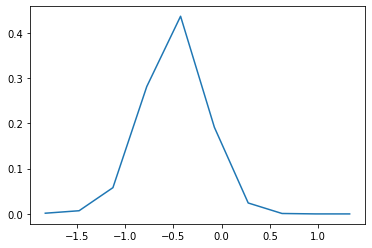

41.84693264961243


In [12]:
# Test of stable single-cell system, using drag lifetime from JASON model

import sys
sys.path.append('./../')

from NCell import NCell
from AtmosphericDecayModels import drag_lifetime, need_update
import matplotlib.pyplot as plt
import numpy as np
from time import time
R = 6371 # radius of earth in km
alt = [575, 625] # altitude band of Starlink satellites (km)
V = 4*np.pi*50*(R+600)**2 # volume of band
S_i = [0]
S_di = [0]
D_i = [0]
N_i = int(2.5e-8*V)
lam = 1000
T = 50
def drag_lifetime_loc(hmax, hmin, a_over_m, t):
    m0 = int(t*12) % 144
    return drag_lifetime(hmax, hmin, 0, 0, a_over_m=a_over_m, dt=100/(60*60*24*365.25), maxdt=0.1, m0=m0)
atmosphere = NCell([S_i], [S_di], [D_i], [N_i], [600], alt, [lam], drag_lifetime_loc, need_update, chi_max=1.5)
print(np.sum(atmosphere.sat_coll_probability_tables[0][0], axis=0))
chi_edges = np.linspace(-2.0, 1.5, num=11)
chi_ave = []
for i in range(0, 10):
    chi_val = (chi_edges[i] + chi_edges[i+1])/2
    chi_ave.append(chi_val)
plt.plot(chi_ave, np.sum(atmosphere.sat_coll_probability_tables[0][0], axis=0)/np.sum(atmosphere.sat_coll_probability_tables[0]))
plt.show()

x = time()
atmosphere.run_sim_euler(T, dt=0.001)
print(time() - x)
#atmosphere.run_sim_precor(T, dt=1, mindtfactor=1000, tolerance=2)

In [2]:
# multi-cell probability table

import sys
sys.path.append('./../')

from NCell import NCell
from AtmosphericDecayModels import drag_lifetime, need_update
import matplotlib.pyplot as plt
import numpy as np
from time import time
R = 6371 # radius of earth in km
alt = np.linspace(300,900,num=26)
S_i = [[0]]*25
S_di = [[0]]*25
D_i = [[0]]*25
N_i = [0]*25
lam = 1000
T = 50
def drag_lifetime_loc(hmax, hmin, a_over_m, t):
    m0 = int(t*12) % 144
    return drag_lifetime(hmax, hmin, 0, 0, a_over_m=a_over_m, dt=100/(60*60*24*365.25), maxdt=0.1, m0=m0)
atmosphere = NCell(S_i, S_di, D_i, N_i, [600], alt, [lam], drag_lifetime_loc, need_update)
print(np.sum(atmosphere.sat_coll_probability_tables[0]))

0.445572862931083


[0.01724087 0.01906013 0.02243324 0.0251939  0.02548533 0.02666977
 0.03701012 0.04757972 0.05060009 0.05001051 0.06581096 0.09536488
 0.09831301 0.07570319 0.05764764 0.04716225 0.04010075 0.0349147
 0.03089015 0.02764853 0.02496756 0.02270636 0.02077017 0.01909227
 0.01762389]
0.570908429252648


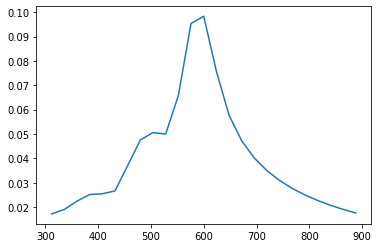

In [9]:
print(np.sum(atmosphere.sat_coll_probability_tables[12], axis=(1,2))/np.sum(atmosphere.sat_coll_probability_tables[12]))
data = np.sum(atmosphere.sat_coll_probability_tables[12], axis=(1,2))/np.sum(atmosphere.sat_coll_probability_tables[12])
print(np.sum(atmosphere.sat_coll_probability_tables[12]))
x_axis = []
for i in range(25):
    x_axis.append((alt[i]+alt[i+1])/2)
plt.plot(x_axis, data)
plt.show()

In [1]:
# Test of stable single-cell system, using drag lifetime from JASON model

import sys
sys.path.append('./../')

from NCell import NCell
from AtmosphericDecayModels import drag_lifetime, need_update
import matplotlib.pyplot as plt
import numpy as np
from time import time
R = 6371 # radius of earth in km
alt = [575, 625] # altitude band of Starlink satellites (km)
V = 4*np.pi*50*(R+600)**2 # volume of band
S_i = [0]
S_di = [0]
D_i = [0]
N_i = int(2.5e-8*V)
lam = 1000
T = 30
def drag_lifetime_loc(hmax, hmin, a_over_m, t):
    m0 = t*12
    return drag_lifetime(hmax, hmin, 0, 0, a_over_m=a_over_m, dt=100/(60*60*24*365.25), maxdt=0.1, m0=m0)
atmosphere = NCell([S_i], [S_di], [D_i], [N_i], [600], alt, [lam], drag_lifetime_loc, need_update, num_dir=1000)
x = time()
atmosphere.run_sim_euler(T, dt=0.001)
print(time() - x)

1.0
0.0
0.0
[[5106.69164769    0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [1690.98453237    0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [ 559.93760461    0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [ 185.41276698    0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [  61.39593747    0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [  20.33010563    0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [   6.73193068    0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [ 362.17115706    0.        

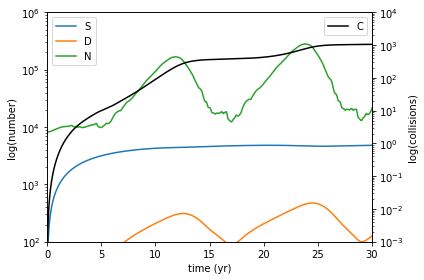

In [2]:
t = atmosphere.get_t()
S = atmosphere.get_S()[0][0]
SD = atmosphere.get_SD()[0][0]
D = atmosphere.get_D()[0][0]
N = atmosphere.get_N()[0]
C = atmosphere.get_C()[0]

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.set_xlabel('time (yr)')
ax1.set_ylabel('log(number)')
ax1.set_yscale('log')
ax1.plot(t, S, label='S')
ax1.plot(t, D, label='D')
ax1.plot(t, N, label='N')
ax1.set_ylim(100, 1e6)
ax1.set_xlim(0,30)
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('log(collisions)')  # we already handled the x-label with ax1
ax2.plot(t, C, label='C', color='k')
ax2.set_ylim(1e-3, 1e4)
ax2.set_yscale('log')
ax2.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()